(128, 17564)


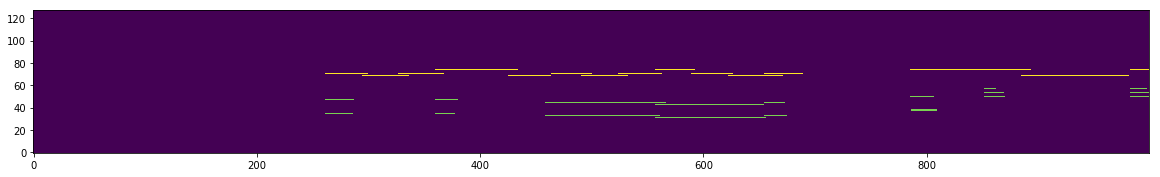

In [1]:
import pretty_midi
f = 'Naruto Shippuden OP 16 COMP.mid'
midi_data = pretty_midi.PrettyMIDI(f)
fs = 200
piano_matrix = midi_data.get_piano_roll(fs=200)

import numpy as np
print(np.shape(piano_matrix))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.imshow(piano_matrix[:,:1000], origin="lower")

In [7]:
# https://github.com/craffel/pretty-midi/blob/master/examples/reverse_pianoroll.py
    
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)
    print(velocity_changes)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

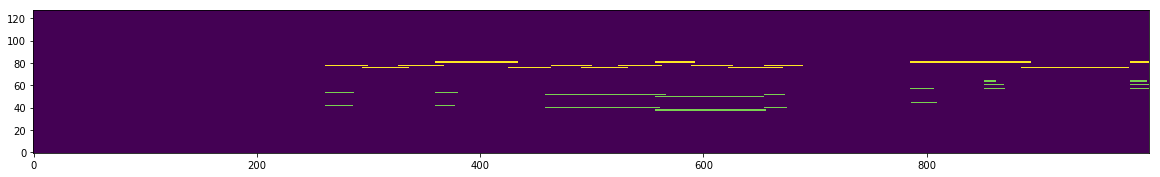

In [8]:
new_piano_matrix = np.zeros(np.shape(piano_matrix))
transpose = 7

highest_note = min(np.shape(piano_matrix)[0]-transpose-1, 127)

for tick in range(np.shape(piano_matrix)[1]):
    for note in range(highest_note):
        new_piano_matrix[note + transpose,tick]  = piano_matrix[note,tick]   
        
plt.figure(figsize = (20,10))
plt.imshow(new_piano_matrix[:,:1000], origin = "lower")

In [9]:
new_midi_data = piano_roll_to_pretty_midi(piano_matrix,fs=200)
new_midi_data.write('foo.mid')

(array([  262,   262,   262, ..., 17541, 17550, 17564]), array([35, 47, 71, ..., 76, 74, 76]))
